In [1]:
from __future__ import division, print_function
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import pandas as pd
import os

Using TensorFlow backend.


In [3]:
def load_and_preprocess_imgs(save_folder):
    imgs = []
    files = [file for file in os.listdir(save_folder) if file.endswith('png')]
    for file in files:
        img_path = os.path.join(save_folder, file)
        img = image.load_img(img_path, target_size=(224, 224))
        imgs.append(image.img_to_array(img))
    
    return preprocess_input(np.asarray(imgs))

In [3]:
X = load_and_preprocess_imgs('../data/images_reuben/')
df = pd.read_csv('../data/images_reuben/data.csv', index_col=0)
shapes = df['shape'].as_matrix()
colors = df['color'].as_matrix()
textures = df['texture'].as_matrix()

In [4]:
X.shape

(20, 224, 224, 3)

In [5]:
model = VGG16(weights='imagenet', include_top=True)

In [62]:
X_h = model.predict(X)
X_h = X_h.reshape(len(X_h), -1)

In [22]:
X_h.shape

(20, 25088)

In [6]:
from scipy.spatial.distance import cosine

def similarity(x1, x2):
    return 1 - cosine(x1, x2)

In [15]:
def evaluate_one(X, i):
    """
    :param X: The (nb_samples, nb_features) feature matrix.
    :param i: The index of the sample we want to compare to others.
    """
    candidates = list(range(len(X)))
    candidates.remove(i)
    for j in candidates:
        print('%0.2i: %0.3f' % (j, similarity(X[i], X[j])))

In [16]:
def evaluate(X, y):
    means_same = []
    means_diff = []
    max_in = 0
    for i, cat in enumerate(y):
        # Find indices of other samples with same category
        inds_same = np.where(y == cat)[0]
        vals_same = [similarity(X[i], X[j]) for j in inds_same]
        # Find indices of other samples with different category
        inds_diff = np.where(y != cat)[0]
        vals_diff = [similarity(X[i], X[j]) for j in inds_diff]
        if max(vals_same) > max(vals_diff):
            max_in += 1
        means_same.append(np.mean(vals_same))
        means_diff.append(np.mean(vals_diff))
            
    return max_in/len(X), np.mean(means_same), np.mean(means_diff)

In [24]:
accuracy, mean_same, mean_diff = evaluate(X_h, shape)
print('Accuracy: %0.2f' % accuracy)
print('Mean cosine distance for correct sample: %0.2f' % mean_same)
print('Mean cosine distance for incorrect sample: %0.2f' % mean_diff)

Accuracy: 1.00
Mean cosine distance for correct sample: 0.83
Mean cosine distance for incorrect sample: 0.26


# Now make a function that can plot shape bias accuracy for a given layer

In [7]:
def compute_representations(X, layer_num, batch_size=256):
    # Build symbolic function to compute output
    get_layer = K.function(
        [model.layers[0].input, K.learning_phase()],
        [model.layers[layer_num].output]
    )
    # Loop through batches and compute output
    n_batches = int(np.ceil(X.shape[0] / batch_size))
    outputs = []
    for i in range(n_batches):
        outputs.append(get_layer([X[i*batch_size:(i+1)*batch_size], 0])[0])

    X = np.concatenate(outputs)
    return X.reshape(len(X), -1)

In [8]:
from itertools import combinations

def accuracy_for_layer(model, X, shape, color, texture, layer_num):
    # Compute hidden representations of the input for a specific
    # hidden layer
    X_h = compute_representations(X, layer_num)
    # Loop through the samples and compute accuracy
    similarities = []
    for y in [shape, color, texture]:
        means_same = []
        for cat in set(y):
            # Find indices of samples with this category
            inds = list(np.where(y == cat)[0])
            scores = [similarity(X_h[i], X_h[j]) for i, j in combinations(inds, 2)]
            means_same.append(np.mean(scores))
        similarities.append(np.mean(means_same))
    
    # normalize the 3 similarities
    similarities = np.asarray(similarities)
    similarities /= np.sum(similarities)
    return similarities

In [9]:
def run_experiment(model, X, shapes, colors, textures, verbose=True):
    shape_vals = []
    color_vals = []
    texture_vals = []
    for i in range(len(model.layers)):
        sim_shape, sim_color, sim_texture = accuracy_for_layer(model, X, shapes, colors, textures, i)
        if verbose:
            print('Results for layer #%i:\n\t shape: %0.3f, color: %0.3f, texture: %0.3f' % 
                  (i, sim_shape, sim_color, sim_texture))
        shape_vals.append(sim_shape)
        color_vals.append(sim_color)
        texture_vals.append(sim_texture)
        
    return shape_vals, color_vals, texture_vals

In [169]:
shape_vals, color_vals, texture_vals = run_experiment(model, X, shapes, colors, textures)

Results for layer #0:
	 shape: 0.347, color: 0.324, texture: 0.330
Results for layer #1:
	 shape: 0.362, color: 0.304, texture: 0.334
Results for layer #2:
	 shape: 0.353, color: 0.312, texture: 0.335
Results for layer #3:
	 shape: 0.370, color: 0.297, texture: 0.333
Results for layer #4:
	 shape: 0.402, color: 0.263, texture: 0.335
Results for layer #5:
	 shape: 0.433, color: 0.229, texture: 0.338
Results for layer #6:
	 shape: 0.454, color: 0.220, texture: 0.327
Results for layer #7:
	 shape: 0.448, color: 0.220, texture: 0.332
Results for layer #8:
	 shape: 0.444, color: 0.227, texture: 0.330
Results for layer #9:
	 shape: 0.476, color: 0.202, texture: 0.323
Results for layer #10:
	 shape: 0.487, color: 0.201, texture: 0.311
Results for layer #11:
	 shape: 0.484, color: 0.203, texture: 0.313
Results for layer #12:
	 shape: 0.500, color: 0.201, texture: 0.299
Results for layer #13:
	 shape: 0.576, color: 0.166, texture: 0.258
Results for layer #14:
	 shape: 0.561, color: 0.178, textu

# Now try w/ Brenden's images

In [4]:
from sklearn.preprocessing import LabelEncoder

def load_and_preprocess_imgs1(save_folder):
    shapes = []
    colors = []
    textures = []
    imgs = []
    files = [file for file in os.listdir(save_folder) if file.endswith('jpg') or file.endswith('png')]
    for file in files:
        shape, texture, color = file.split('_')
        color = color[:-4]
        shapes.append(shape)
        textures.append(texture)
        colors.append(color)
        img_path = os.path.join(save_folder, file)
        img = image.load_img(img_path, target_size=(224, 224))
        imgs.append(image.img_to_array(img))
        
    le = LabelEncoder()
    shapes = le.fit_transform(shapes)
    colors = le.fit_transform(colors)
    textures = le.fit_transform(textures)
    
    return preprocess_input(np.asarray(imgs)), shapes, colors, textures

In [5]:
X1, shapes1, colors1, textures1 = load_and_preprocess_imgs1('../data/images_brenden/')
print(X1.shape)

(80, 224, 224, 3)


In [45]:
#shape_vals1, color_vals1, texture_vals1 = run_experiment(model, X1, shapes1, colors1, textures1)
shape_vals1 = np.load('../data/images_brenden/shape_vals.npy')
color_vals1 = np.load('../data/images_brenden/color_vals.npy')
texture_vals1 = np.load('../data/images_brenden/texture_vals.npy')

In [44]:
# np.save('../data/images_brenden/shape_vals.npy', shape_vals1)
# np.save('../data/images_brenden/color_vals.npy', color_vals1)
# np.save('../data/images_brenden/texture_vals.npy', texture_vals1)

In [13]:
model.layers

In [14]:
x_grid = list(range(len(model.layers)))
#labels = ['layer%0.2i'%i for i, _ in enumerate(x_grid)]
layers = ['Input', 'Conv1', 'Conv2', 'MaxPool1', 'Conv3', 'Conv4', 'MaxPool2',
          'Conv5', 'Conv6', 'Conv7', 'MaxPool3', 'Conv8', 'Conv9', 'Conv10', 
          'MaxPool4', 'Conv11', 'Conv12', 'Conv13', 'MaxPool5', 'Flatten',
          'Dense1', 'Dense2', 'Softmax']

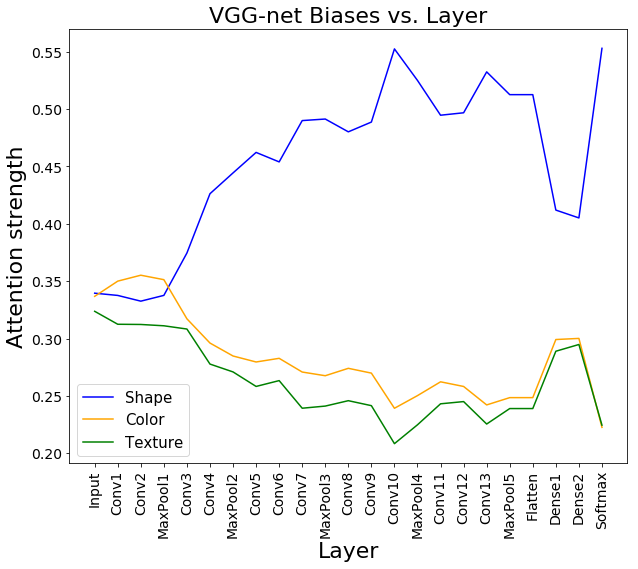

In [15]:
%matplotlib inline
import matplotlib.pylab as plt

plt.figure(figsize=(10,8))
plt.title('VGG-net Biases vs. Layer', fontsize=22)
plt.plot(x_grid, shape_vals1, label='Shape', color='blue')
plt.plot(x_grid, color_vals1, label='Color', color='orange')
plt.plot(x_grid, texture_vals1, label='Texture', color='green')
plt.yticks(fontsize=14)
plt.ylabel('Attention strength', fontsize=22)
plt.xticks(x_grid, layers, rotation='vertical', fontsize=14)
plt.xlabel('Layer', fontsize=22)
plt.legend(prop={'size': 15}, loc=3)
plt.show()

### Remove unneccesary layers

In [16]:
inds_keep = [1,2,4,5,7,8,9,11,12,13,15,16,17,20,21]
print([layers[i] for i in inds_keep])

['Conv1', 'Conv2', 'Conv3', 'Conv4', 'Conv5', 'Conv6', 'Conv7', 'Conv8', 'Conv9', 'Conv10', 'Conv11', 'Conv12', 'Conv13', 'Dense1', 'Dense2']


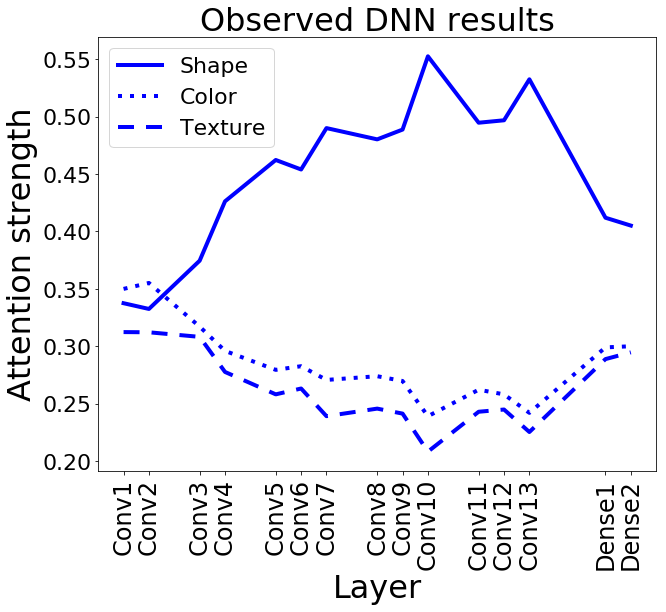

In [46]:
x_grid_1 = [x_grid[i] for i in inds_keep]
layers_1 = [layers[i] for i in inds_keep]
shape_vals1_1 = [shape_vals1[i] for i in inds_keep]
color_vals1_1 = [color_vals1[i] for i in inds_keep]
texture_vals1_1 = [texture_vals1[i] for i in inds_keep]

plt.figure(figsize=(10,8))
plt.title('Observed DNN results', fontsize=32)
plt.plot(x_grid_1, shape_vals1_1, label='Shape', color='blue', linewidth=4)
plt.plot(x_grid_1, color_vals1_1, ls=(0, (1, 2)), label='Color', color='blue', linewidth=4)
plt.plot(x_grid_1, texture_vals1_1, ls=(0, (4, 3)), label='Texture', color='blue', linewidth=4)
plt.yticks(fontsize=22)
plt.ylabel('Attention strength', fontsize=32)
plt.xticks(x_grid_1, layers_1, rotation='vertical', fontsize=24)
plt.xlabel('Layer', fontsize=32)
plt.legend(prop={'size': 22}, loc=2)
plt.savefig('/Users/reubenfeinman/Dropbox/NYU/fellowships/NSF/figures/layer-results-DNN.pdf', 
            format='pdf',
            bbox_inches='tight')
plt.show()

In [18]:
def normalize(shape_vals, color_vals, texture_vals):
    s = shape_vals + color_vals + texture_vals
    return shape_vals/s, color_vals/s, texture_vals/s

In [19]:
def get_others(shape_vals, scale=0.1):
    #shape_vals = np.random.normal(loc=shape_vals, scale=scale, size=shape_vals.shape)
    mean = (np.max(shape_vals) - shape_vals)
    color_vals = np.random.normal(loc=mean, scale=scale, size=shape_vals.shape)
    texture_vals = np.random.normal(loc=mean, scale=scale, size=shape_vals.shape)
    shape_vals, color_vals, texture_vals = normalize(shape_vals, color_vals, texture_vals)
    
    #texture_vals = 1 - shape_vals - color_vals
    return shape_vals, color_vals, texture_vals

In [22]:
from scipy.special import expit

grid = np.linspace(-4, 4, 15)
shape_bias_brain1 = expit(grid)
shape_bias_brain1, color_bias_brain1, texture_bias_brain1 = get_others(shape_bias_brain1, scale=0.03)

In [23]:
shape_bias_brain2 = 0.5*np.ones(15,)
shape_bias_brain2, color_bias_brain2, texture_bias_brain2 = get_others(shape_bias_brain2, scale=0.03)

In [24]:
grid1 = np.linspace(1, 10000, 15)
shape_bias_brain3 = np.power(grid1,1/10)
shape_bias_brain3, color_bias_brain3, texture_bias_brain3 = get_others(shape_bias_brain3, scale=0.1)
# plt.figure()
# plt.plot(grid1, shape_bias_brain3)
# plt.show()

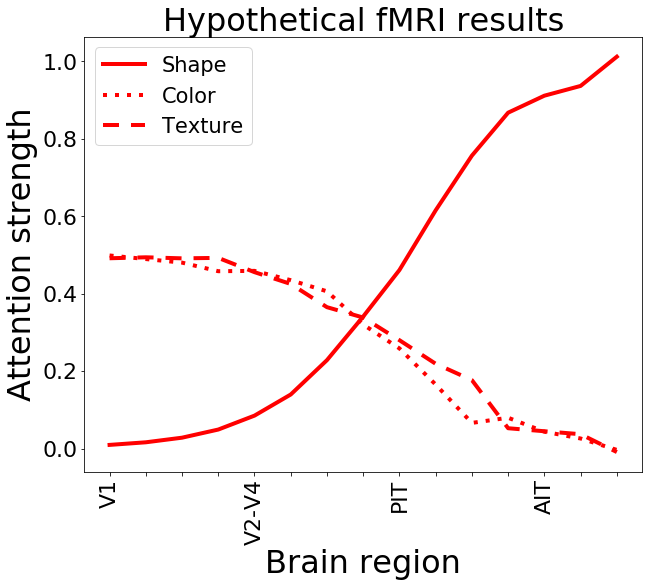

In [41]:
from scipy.special import expit

grid = np.linspace(-4, 4, 15)
layers_brain = ['V1', '', '', '',
                'V2-V4', '', '', '', 
                'PIT', '', '', '',
                'AIT']

plt.figure(figsize=(10,8))
plt.title('Hypothetical fMRI results', fontsize=32)
# 1
plt.plot(grid, shape_bias_brain1, color='red', linewidth=4, label='Shape')
plt.plot(grid, color_bias_brain1, ls=(0, (1, 2)), color='red', linewidth=4, label='Color')
plt.plot(grid, texture_bias_brain1, ls=(0, (4, 3)), color='red', linewidth=4, label='Texture')
# # 2
# plt.plot(grid, shape_bias_brain2, color='purple', linewidth=4, label='2?')
# plt.plot(grid, color_bias_brain2, ls=(0, (1, 2)), color='purple', linewidth=4)
# plt.plot(grid, texture_bias_brain2, ls=(0, (4, 3)), color='purple', linewidth=4)
# # 3
# plt.plot(grid, shape_bias_brain3, color='green', linewidth=4, label='3?')
# plt.plot(grid, color_bias_brain3, ls=(0, (1, 2)), color='green', linewidth=4)
# plt.plot(grid, texture_bias_brain3, ls=(0, (4, 3)), color='green', linewidth=4)
plt.yticks(fontsize=22)
plt.ylabel('Attention strength', fontsize=32)
plt.xticks(grid, layers_brain, rotation='vertical', fontsize=22)
plt.xlabel('Brain region', fontsize=32)
plt.legend(prop={'size': 21}, loc=2)
plt.savefig('/Users/reubenfeinman/Dropbox/NYU/fellowships/NSF/figures/layer-results-brain.pdf', 
            format='pdf',
            bbox_inches='tight')
plt.show()

# Plot images side by side for the github wiki

In [151]:
from scipy.ndimage import imread

imgs = np.asarray(
    [imread(os.path.join('../data/image_dataset', 'img%0.4i.png' % i)) 
     for i in range(20)]
)

In [152]:
imgs.shape

(20, 400, 400, 4)

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt

In [150]:
# f, ax = plt.subplots(3, 2, figsize=(15, 20))
# ax[0,0].imshow(imgs[0])
# ax[0,1].imshow(imgs[1])
# ax[1,0].imshow(imgs[2])
# ax[1,1].imshow(imgs[3])
# ax[2,0].imshow(imgs[12])
# ax[2,1].imshow(imgs[13])
# ax[0,0].title.set_text('Shape 0, Color 1, Texture 1') #0
# ax[0,1].title.set_text('Shape 0, Color 9, Texture 5') #1
# ax[1,0].title.set_text('Shape 1, Color 3, Texture 0') #2
# ax[1,1].title.set_text('Shape 1, Color 7, Texture 9') #3
# ax[2,0].title.set_text('Shape 6, Color 1, Texture 7') #12
# ax[2,1].title.set_text('Shape 6, Color 4, Texture 7') #13
# ax[0,0].axis('off')
# ax[0,1].axis('off')
# ax[1,0].axis('off')
# ax[1,1].axis('off')
# ax[2,0].axis('off')
# ax[2,1].axis('off')
# plt.show()
# f.savefig('../data/image_examples.png')